# Semi-supervised Learning

* Preparing and executing partially and delayed labeling experiments

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 20/10/2025**

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_ssl_evaluation
from capymoa.datasets import Electricity

## 1. Learning using a SSL classifier

* This example uses the OSNN algorithm to learn from a stream with only 1% labeled data
* We utilize the `prequential_ssl_evaluation()` function to simulate the absence of labels (`label_probability`) and delays (`delay_length`)
* The results yield by `prequential_ssl_evaluation()` include more information in comparison to `prequential_evaluation()`, such as the number of unlabeled instances (`unlabeled`) and the unlabeled ratio (`unlabeled_ratio`). 

In [3]:
help(prequential_ssl_evaluation)

Help on function prequential_ssl_evaluation in module capymoa.evaluation.evaluation:

prequential_ssl_evaluation(stream: capymoa.stream._stream.Stream, learner: Union[capymoa.base._ssl.ClassifierSSL, capymoa.base._classifier.Classifier], max_instances: Optional[int] = None, window_size: int = 1000, initial_window_size: int = 0, delay_length: int = 0, label_probability: float = 0.01, random_seed: int = 1, store_predictions: bool = False, store_y: bool = False, optimise: bool = True, restart_stream: bool = True, progress_bar: Union[bool, tqdm.std.tqdm] = False, batch_size: int = 1)
    Run and evaluate a learner on a semi-supervised stream using prequential evaluation.
    
    :param stream: A data stream to evaluate the learner on. Will be restarted if
        ``restart_stream`` is True.
    :param learner: The learner to evaluate. If the learner is an SSL learner,
        it will be trained on both labeled and unlabeled instances. If the
        learner is not an SSL learner, then it 

51.15


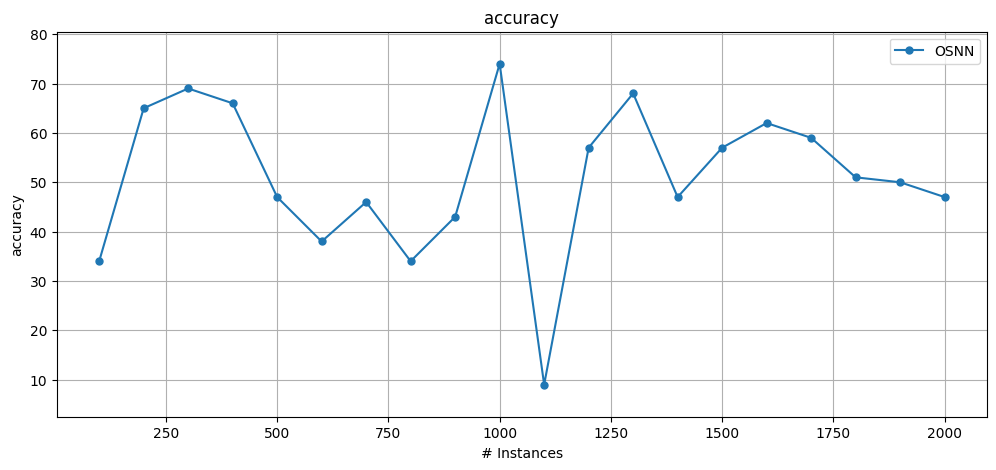

In [14]:
from capymoa.ssl import OSNN

stream = Electricity()

osnn = OSNN(schema=stream.get_schema(), optim_steps=10)

results_osnn = prequential_ssl_evaluation(
    stream=stream,
    learner=osnn,
    label_probability=0.01,
    window_size=100,
    max_instances=2000,
)

# The results are stored in a dictionary.
display(results_osnn)

print(
    results_osnn["cumulative"].accuracy()
)  # Test-then-train accuracy, i.e. cumulatively, not windowed.

# Plotting over time (default: classifications correct (percent) i.e. accuracy)
results_osnn.learner = "OSNN"
plot_windowed_results(results_osnn, metric="accuracy")

## 1.1 Using a supervised model

* If a supervised model is used with `prequential_ssl_evaluation()` it will only be trained on the labeled data



In [15]:
from capymoa.classifier import StreamingRandomPatches

srp10 = StreamingRandomPatches(schema=stream.get_schema(), ensemble_size=10)

results_srp10 = prequential_ssl_evaluation(
    stream=stream,
    learner=srp10,
    label_probability=0.01,
    window_size=100,
    max_instances=2000,
)
print(results_srp10["cumulative"].accuracy())

55.35


## 1.2 SLEADE

Another semi-supervised learning algorithm (SLEADE)

In [21]:
from capymoa.ssl import SLEADE
from capymoa.datasets import ElectricityTiny
from capymoa.evaluation import prequential_evaluation

stream = Electricity()

sleade = SLEADE(schema=stream.get_schema(), base_ensemble="StreamingRandomPatches -s 10")

results_sleade = prequential_ssl_evaluation(
    stream=stream,
    learner=sleade,
    label_probability=0.01,
    window_size=100,
    max_instances=2000,
)

print(results_sleade["cumulative"].accuracy())

58.050000000000004


## 1.3 Comparing a SSL and supervised classifiers

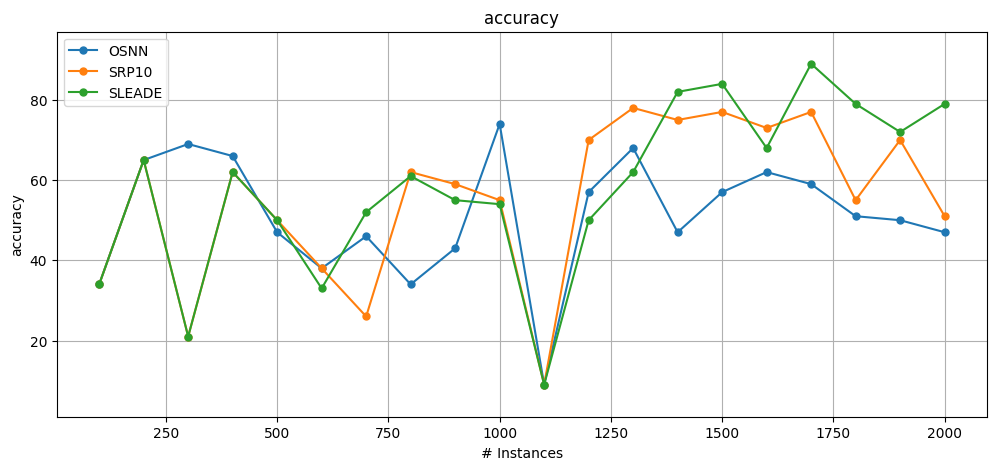

In [19]:
# Plotting all the results together
# Adding an experiment_id to the results dictionary allows controlling the legend of each learner.
results_osnn.learner = "OSNN"
results_srp10.learner = "SRP10"
results_sleade.learner = "SLEADE"

plot_windowed_results(results_osnn, results_srp10, results_sleade, metric="accuracy")

## 2. Delay example
* Comparing the effect of delay on a stream
* It is particularly interesting to see the effect after a drift takes place. 

Accuracy immediate: 84.517
Accuracy delayed by 1000 instances: 83.366


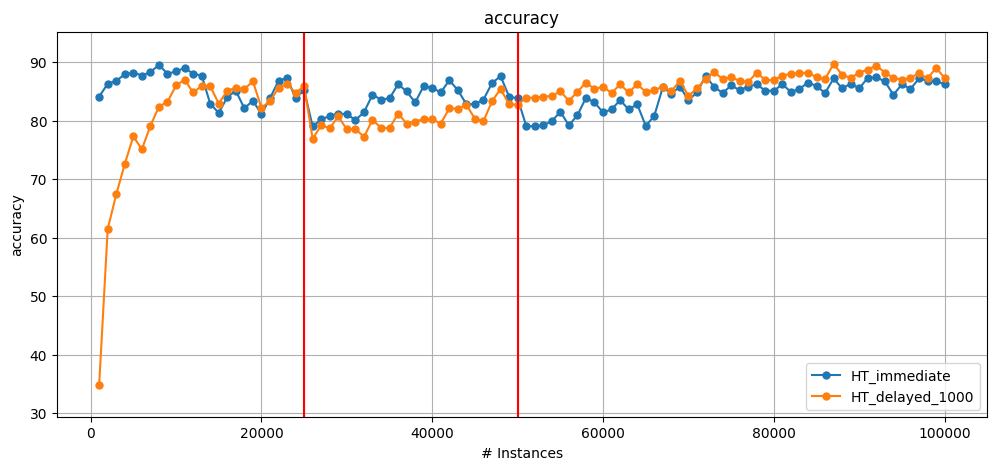

In [20]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import DriftStream, AbruptDrift
from capymoa.classifier import HoeffdingTree

## Creating a stream with drift
sea2drifts = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=25000),
        SEA(function=2),
        AbruptDrift(position=50000),
        SEA(function=3),
    ]
)


ht_immediate = HoeffdingTree(schema=sea2drifts.get_schema())
ht_delayed = HoeffdingTree(schema=sea2drifts.get_schema())

results_ht_immediate = prequential_ssl_evaluation(
    stream=sea2drifts,
    learner=ht_immediate,
    label_probability=0.1,
    window_size=1000,
    max_instances=100000,
)

results_ht_delayed_1000 = prequential_ssl_evaluation(
    stream=sea2drifts,
    learner=ht_delayed,
    label_probability=0.01,
    delay_length=1000,  # adding the delay
    window_size=1000,
    max_instances=100000,
)

results_ht_immediate.learner = "HT_immediate"
results_ht_delayed_1000.learner = "HT_delayed_1000"

print(f"Accuracy immediate: {results_ht_immediate['cumulative'].accuracy()}")
print(
    f"Accuracy delayed by 1000 instances: {results_ht_delayed_1000['cumulative'].accuracy()}"
)

plot_windowed_results(results_ht_immediate, results_ht_delayed_1000, metric="accuracy")

## SLEADE

In [9]:
from __future__ import annotations
from typing import Union

from capymoa.base import MOAClassifierSSL
from capymoa._utils import build_cli_str_from_mapping_and_locals
from capymoa.stream import Schema
import moa.classifiers.semisupervised as moa_ssl


class SLEADE(MOAClassifierSSL):
    """Semi-supervised SLEADE ensemble.

    SLEADE (Semi-supervised Learning with Ensemble Agreement and Drift Estimation)
    extends streaming ensemble methods to handle partially labelled data and
    unsupervised drift detection.

    >>> from capymoa.classifier import SLEADE
    >>> from capymoa.datasets import ElectricityTiny
    >>> from capymoa.evaluation import prequential_evaluation
    >>>
    >>> stream = ElectricityTiny()
    >>> clf = SLEADE(stream.get_schema())
    >>> results = prequential_evaluation(stream, clf, max_instances=1000)
    >>> print(f"{results['cumulative'].accuracy():.1f}")

    """

    def __init__(
        self,
        schema: Schema | None = None,
        random_seed: int = 0,
        base_ensemble: str = "StreamingRandomPatches",
        confidence_strategy: str = "ArgMax",
        enable_random_threshold: bool = False,
        auto_weight_shrinkage: str = "LabeledNoWarmupDivTotal",
        ssl_strategy: str = "PseudoLabelCheckConfidence",
        ssl_min_confidence: float = 0.0,
        weight_function: str = "ConfidenceWeightShrinkage",
        pairing_function: str = "MajorityTrainsMinority",
        ssl_weight_shrinkage: float = 100.0,
        use_unsupervised_drift_detection: bool = False,
        student_learner_for_unsupervised_drift_detection: str = (
            "trees.HoeffdingTree -g 50 -c 0.01"
        ),
        drift_detection_method: str = "ADWINChangeDetector -a 1.0E-5",
        unsupervised_detection_weight_window: int = 20,
        labeled_window_limit: int = 100,
    ):
        """Construct the SLEADE semi-supervised ensemble.

        :param schema: Stream schema.
        :param random_seed: Random seed.
        :param base_ensemble: Base ensemble learner (e.g., StreamingRandomPatches).
        :param confidence_strategy: Confidence strategy ('Sum' or 'ArgMax').
        :param enable_random_threshold: Use random min-confidence threshold.
        :param auto_weight_shrinkage: Strategy for automatic weight shrinkage.
        :param ssl_strategy: Semi-supervised learning strategy.
        :param ssl_min_confidence: Minimum confidence to accept pseudo-label.
        :param weight_function: Function for weighting pseudo-labelled instances.
        :param pairing_function: Learner pairing function.
        :param ssl_weight_shrinkage: Pseudo-label weight shrinkage value.
        :param use_unsupervised_drift_detection: Whether to enable unsupervised drift detection.
        :param student_learner_for_unsupervised_drift_detection: Student model for drift detection.
        :param drift_detection_method: Drift detection algorithm and parameters.
        :param unsupervised_detection_weight_window: Window size for unsupervised drift detection weighting.
        :param labeled_window_limit: Maximum number of labelled instances in buffer.
        """

        mapping = {
            "base_ensemble": "-l",
            "confidence_strategy": "-b",
            "enable_random_threshold": "-q",
            "auto_weight_shrinkage": "-e",
            "ssl_strategy": "-p",
            "ssl_min_confidence": "-m",
            "weight_function": "-w",
            "pairing_function": "-t",
            "ssl_weight_shrinkage": "-n",
            "use_unsupervised_drift_detection": "-s",
            "student_learner_for_unsupervised_drift_detection": "-g",
            "drift_detection_method": "-x",
            "unsupervised_detection_weight_window": "-z",
            "labeled_window_limit": "-j",
        }

        # Build CLI string (handles nested learners if applicable)
        config_str = build_cli_str_from_mapping_and_locals(mapping, locals())

        super(SLEADE, self).__init__(
            moa_learner=moa_ssl.SLEADE,
            schema=schema,
            CLI=config_str,
            random_seed=random_seed,
        )


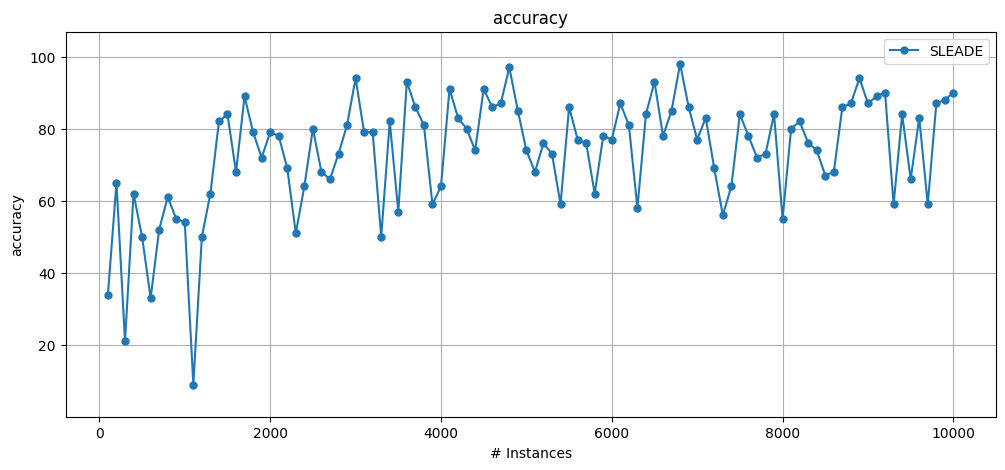

In [10]:
from capymoa.classifier import EFDT
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_ssl_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

stream = Electricity()

sleade_py = SLEADE(schema=stream.get_schema(), base_ensemble="StreamingRandomPatches -s 10")

# print(sleade.cli_help())
# type(sleade)
type(sleade_py)
results_sleade_py = prequential_ssl_evaluation(
    stream=stream,
    learner=sleade_py,
    label_probability=0.01,
    window_size=100,
    max_instances=10000,
)

# # The results are stored in a dictionary.
# display(results_sleade_py)

# print(results_sleade_py["cumulative"].accuracy())

# # Plotting over time (default: classifications correct (percent) i.e. accuracy)
# results_sleade.learner = "sleade_py"
plot_windowed_results(results_sleade_py, metric="accuracy")
# plot_windowed_results(results_sleade, results_sleade_py, metric="accuracy")

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

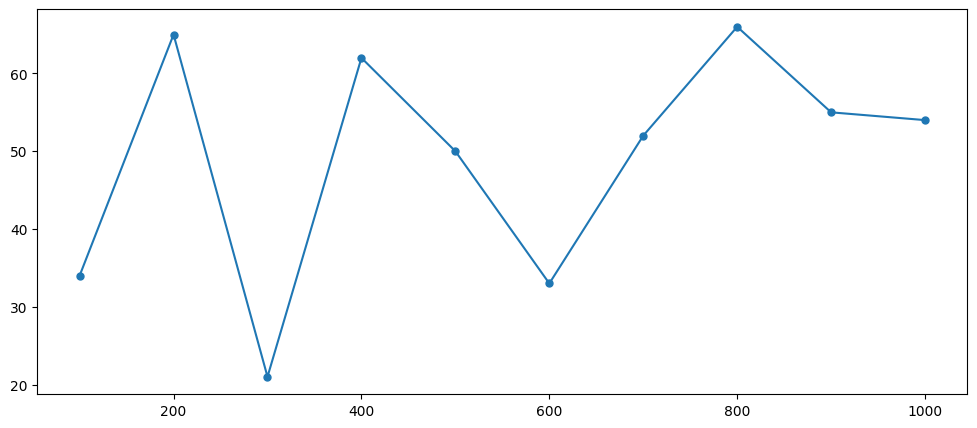

In [11]:
from capymoa.evaluation.visualization import plot_windowed_results

plot_windowed_results(results_sleade, results_sleade_py, metric="accuracy")

In [6]:
plot_windowed_results(results_sleade, results_sleade_py, metric="accuracy")

NameError: name 'plot_windowed_results' is not defined

72.95


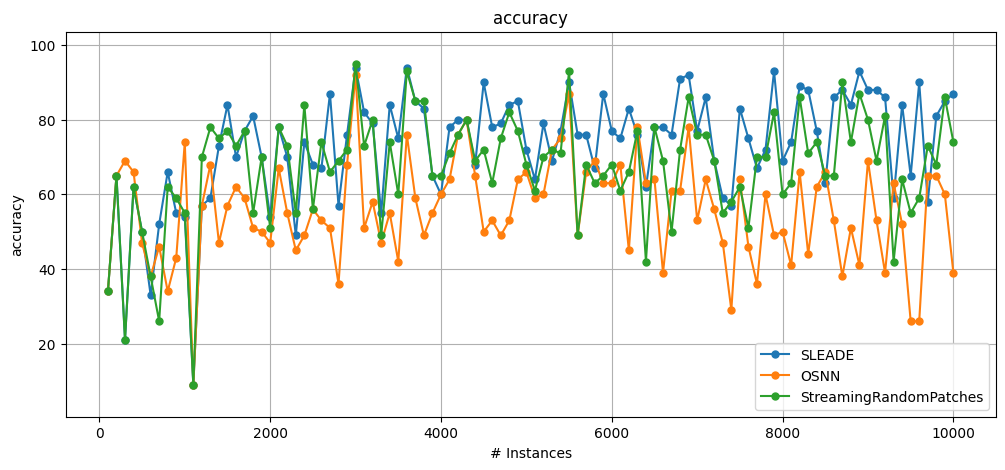

In [24]:
from capymoa.base import MOAClassifierSSL
from moa.classifiers.semisupervised import SLEADE

stream = Electricity()

sleade = MOAClassifierSSL(schema=stream.get_schema(), moa_learner=SLEADE)

# print(sleade.cli_help())


results_sleade = prequential_ssl_evaluation(
    stream=stream,
    learner=sleade,
    label_probability=0.01,
    window_size=100,
    max_instances=10000,
)

# The results are stored in a dictionary.
display(results_sleade)

print(results_sleade["cumulative"].accuracy())

# Plotting over time (default: classifications correct (percent) i.e. accuracy)
results_sleade.learner = "SLEADE"
plot_windowed_results(results_sleade, results_osnn, results_srp10, metric="accuracy")

90.7
